# Setup

#Data collection

## Install VirtualHome (Colab)

In [ ]:
import matplotlib.pyplot as plt
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    !pip install git+https://github.com/xavierpuigf/colabstreamer
    !git clone https://github.com/xavierpuigf/virtualhome.git
    import colabstreamer
    colabstreamer.config_all()
    _xorg = colabstreamer.open_xorg()
    display = "0"
else:  
    import getpass
    import os
    password = getpass.getpass()
    %cd ../..
    !git clone https://github.com/xavierpuigf/virtualhome.git
    %cd virtualhome/helper_scripts
    command = 'sudo -S python startx.py 1'
    display = "1"
    os.popen(command, 'w').write(password+'\n')
    %cd ../../
    

Running on CoLab
  Cloning https://github.com/xavierpuigf/colabstreamer to /tmp/pip-req-build-1e3g1nql
  Running command git clone -q https://github.com/xavierpuigf/colabstreamer /tmp/pip-req-build-1e3g1nql
     |████████████████████████████████| 179 kB 13.5 MB/s 
  Created wheel for colabstreamer.py: filename=colabstreamer.py-0.1-py3-none-any.whl size=3830 sha256=98f8fbcc53edc41f6ecd3e70c55bbac348ebc8b8e3cf014a285faa9413a8db82
  Stored in directory: /tmp/pip-ephem-wheel-cache-uxk0m70v/wheels/7e/df/62/68e8e5813ab1ac489ca123bc4051459c61ba909df0ec7ac404
Successfully built colabstreamer.py
Cloning into 'virtualhome'...
remote: Enumerating objects: 27204, done.
remote: Counting objects: 100% (588/588), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 27204 (delta 380), reused 558 (delta 365), pack-reused 26616
Receiving objects: 100% (27204/27204), 287.36 MiB | 34.49 MiB/s, done.
Resolving deltas: 100% (17649/17649), done.
Will Install xvfb
Will Install xserver-xorg
W

In [ ]:
# Download the simulator
! wget http://virtual-home.org/linux_exec.zip
! unzip -q linux_exec.zip
import os
fpath = os.getcwd()

--2022-04-21 02:01:24--  http://virtual-home.org/linux_exec.zip
Resolving virtual-home.org (virtual-home.org)... 128.30.100.223
Connecting to virtual-home.org (virtual-home.org)|128.30.100.223|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 901763908 (860M) [application/zip]
Saving to: ‘linux_exec.zip’

linux_exec.zip      100%[===================>] 859.99M  5.56MB/s    in 4m 37s  

2022-04-21 02:06:02 (3.10 MB/s) - ‘linux_exec.zip’ saved [901763908/901763908]



In [ ]:
fpath

'/content'

In [ ]:
#if this cell fails run it twice
%matplotlib notebook
import IPython.display
import sys
sys.path.append('./virtualhome')
from simulation.unity_simulator import comm_unity
import demo.utils_demo as utils_demo

## Import Virtualhome Library

In [ ]:
%cd virtualhome

/content/virtualhome


In [ ]:
%matplotlib notebook
%cd demo
import IPython.display
import glob
from utils_demo import *
from sys import platform
import sys
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
sys.path.append('../simulation')
from unity_simulator.comm_unity import UnityCommunication
from unity_simulator import utils_viz

/content/virtualhome/demo


In [ ]:
!pip install num2words

     |████████████████████████████████| 101 kB 6.2 MB/s 


## Convert word into templated sentence

Convert goals

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import re
from num2words import num2words
def goal_translate(goals):
    goal_trans = ''
    sub_goal = ''
    for goal in goals:
        act = re.findall(r'\w+\b', goal)
        if len(act)==2:
            sub_goal = '{} the {}'.format(act[0],act[1])
        if len(act)==4:
            sub_goal = 'put {} {} {} {}'.format(num2words(act[3]),act[1], act[0], act[2])
        goal_trans = goal_trans + sub_goal + ', '
    goal_trans = goal_trans.lower()
    goal_trans = goal_trans[:-2] + '.'
    return goal_trans

goals = ['INSIDE (cutleryfork, dishwasher): 3','ON (wineglass, sink): 2','INSIDE (waterglass, dishwasher): 1',
         'CLOSE (dishwasher)','TURNON (dishwasher)']
print(goal_translate(goals))

put three cutleryfork inside dishwasher, put two wineglass on sink, put one waterglass inside dishwasher, close the dishwasher, turnon the dishwasher.


Convert history

In [ ]:
verb_trans = {'standup': 'stood up',
              'walk': 'walked to',
              'sit': 'sit on',
              'grab': 'grabbed',
              'open': 'opened',
              'close': 'closed',
              'switchon': 'switched on',
              'switchoff': 'switched off',
              'put': ['put', 'on'],
              'putin': ['put', 'inside']}

def history_translate(history):
    if not history: return ''
    history_trans = 'I have '
    for sub in history:
        sub = sub.split(' ')
        if len(sub) == 2:
            history_trans +=  '{}, '.format(verb_trans[sub[1][1: -1]])
        elif len(sub) == 4:
            history_trans += '{} the {}, '.format(verb_trans[sub[1][1: -1]], sub[2][1: -1])
        elif len(sub) == 6:
            history_trans += '{} the {} {} the {}, '.format(verb_trans[sub[1][1: -1]][0], sub[2][1: -1], verb_trans[sub[1][1: -1]][1], sub[4][1: -1])
    history_trans = history_trans[:-2] + '.'
    return history_trans

history = ['<char0> [walk] <coffeepot> (161)', '<char0> [grab] <coffeepot> (161)']
history_translate(history)

'I have walked to the coffeepot, grabbed the coffeepot.'

## Get Partial Observations

Get virtualhome

Define the functions to add a character into the environment, get the objects that are visible in the character's view, obtain the name, state and positions of these objects, and get the edge information among objects

In [ ]:
%cd ..

/content/virtualhome


In [ ]:
#define env data parsers

def create_character(character, room):
    comm.add_character(character, initial_room=room)
    _, graph = comm.environment_graph()
    character_index = [node['id'] for node in graph['nodes'] if node['class_name'] == 'character'][-1]
    return character_index

def get_rooms_id(graph):
    #_, graph = comm.environment_graph()
    rooms_id = [node['id'] for node in graph['nodes'] if node['category'] == 'Rooms']
    return set(rooms_id)

def get_visible_objects_id(character_index , graph):
    #_, graph = comm.environment_graph()
    room_id = [edge['to_id'] for edge in graph['edges'] if edge['from_id'] == character_index and edge['relation_type'] == 'INSIDE'][-1]
    visible_objects_id_set = [edge['from_id'] for edge in graph['edges'] if edge['to_id'] == room_id and edge['relation_type'] == 'INSIDE' and edge['from_id'] != character_index]
    visible_objects_id_set = set(visible_objects_id_set)
    return visible_objects_id_set

def get_observations(character_index, visible_objects_id_set, graph):
    #_, graph = comm.environment_graph()
    character_position = [node for node in graph['nodes'] if node['id'] == character_index][0]['obj_transform']['position']
    ids, names, states, positions = [], [], [], []
    for node in graph['nodes']:
        if node['id'] in visible_objects_id_set:
            states_vector = [0, 0, 0, 0, 0, 0]
            if len(node['states']) == 0:
                states_vector[-1] = 1
            for state in node['states']:
                states_vector[state_index[state]] += 1
            ids += [node['id']]
            names += [node['class_name']]
            states += [states_vector]
            positions += [node['obj_transform']['position'] + list(np.array(node['obj_transform']['position']) - np.array(character_position))]
    
    #append to 256 (at most 256 nodes at an observation)
    while len(ids) < 256:
        ids.append(-1)
        states.append([0,0,0,0,0,0])
        positions.append([0,0,0,0,0,0])

    return {'ids': np.array(ids), 'names':np.array(names), 'states':np.array(states), 'positions':np.array(positions)}


def get_relationships(character_index, observations, graph):
    #_, graph = comm.environment_graph()
    room_id = [edge['to_id'] for edge in graph['edges'] if edge['from_id'] == character_index and edge['relation_type'] == 'INSIDE'][-1]
    sitting_edges = set()
    close_edges = set()
    inside_edges = set()
    hold_edges = set()
    for edge in graph['edges']:
        if edge['to_id'] in observations['ids'] and edge['from_id'] == character_index:
            if edge['relation_type'] == 'SITTING':
                sitting_edges.add(edge['to_id'])
            elif edge['relation_type'] == 'CLOSE':
                close_edges.add(edge['to_id'])
            elif edge['relation_type'] == 'HOLDS_RH' or edge['relation_type'] == 'HOLDS_LH':
                hold_edges.add(edge['to_id'])
        if edge['from_id'] in observations:
            to_id_ind = np.where(observations['ids']==edge['to_id'])
            if edge['relation_type'] == 'INSIDE' and \
              edge['to_id'] != room_id and \
              'CONTAINERS' in properties[observations['names'][to_id_ind]] and\
              observations['states'][to_id_ind][1] == 1:
                inside_edges.add(edge['from_id'])
    relationships ={'sitting': list(sitting_edges),
                    'close': list(close_edges),
                    'inside': list(inside_edges),
                    'hold': list(hold_edges)}
    return relationships


In [142]:
comm = comm_unity.UnityCommunication(file_name=f"{fpath}/linux_exec.x86_64", port='8098', x_display=display)
comm.reset(5)
character_id = create_character('chars/Female2', 'kitchen')

['/content/linux_exec.x86_64', '-batchmode', '-http-port=8098', '-logFile /content/virtualhome/Player_8098.log']
Getting connection...


In [147]:
comm.reset(5)
character_id = create_character('chars/Female2', 'kitchen')

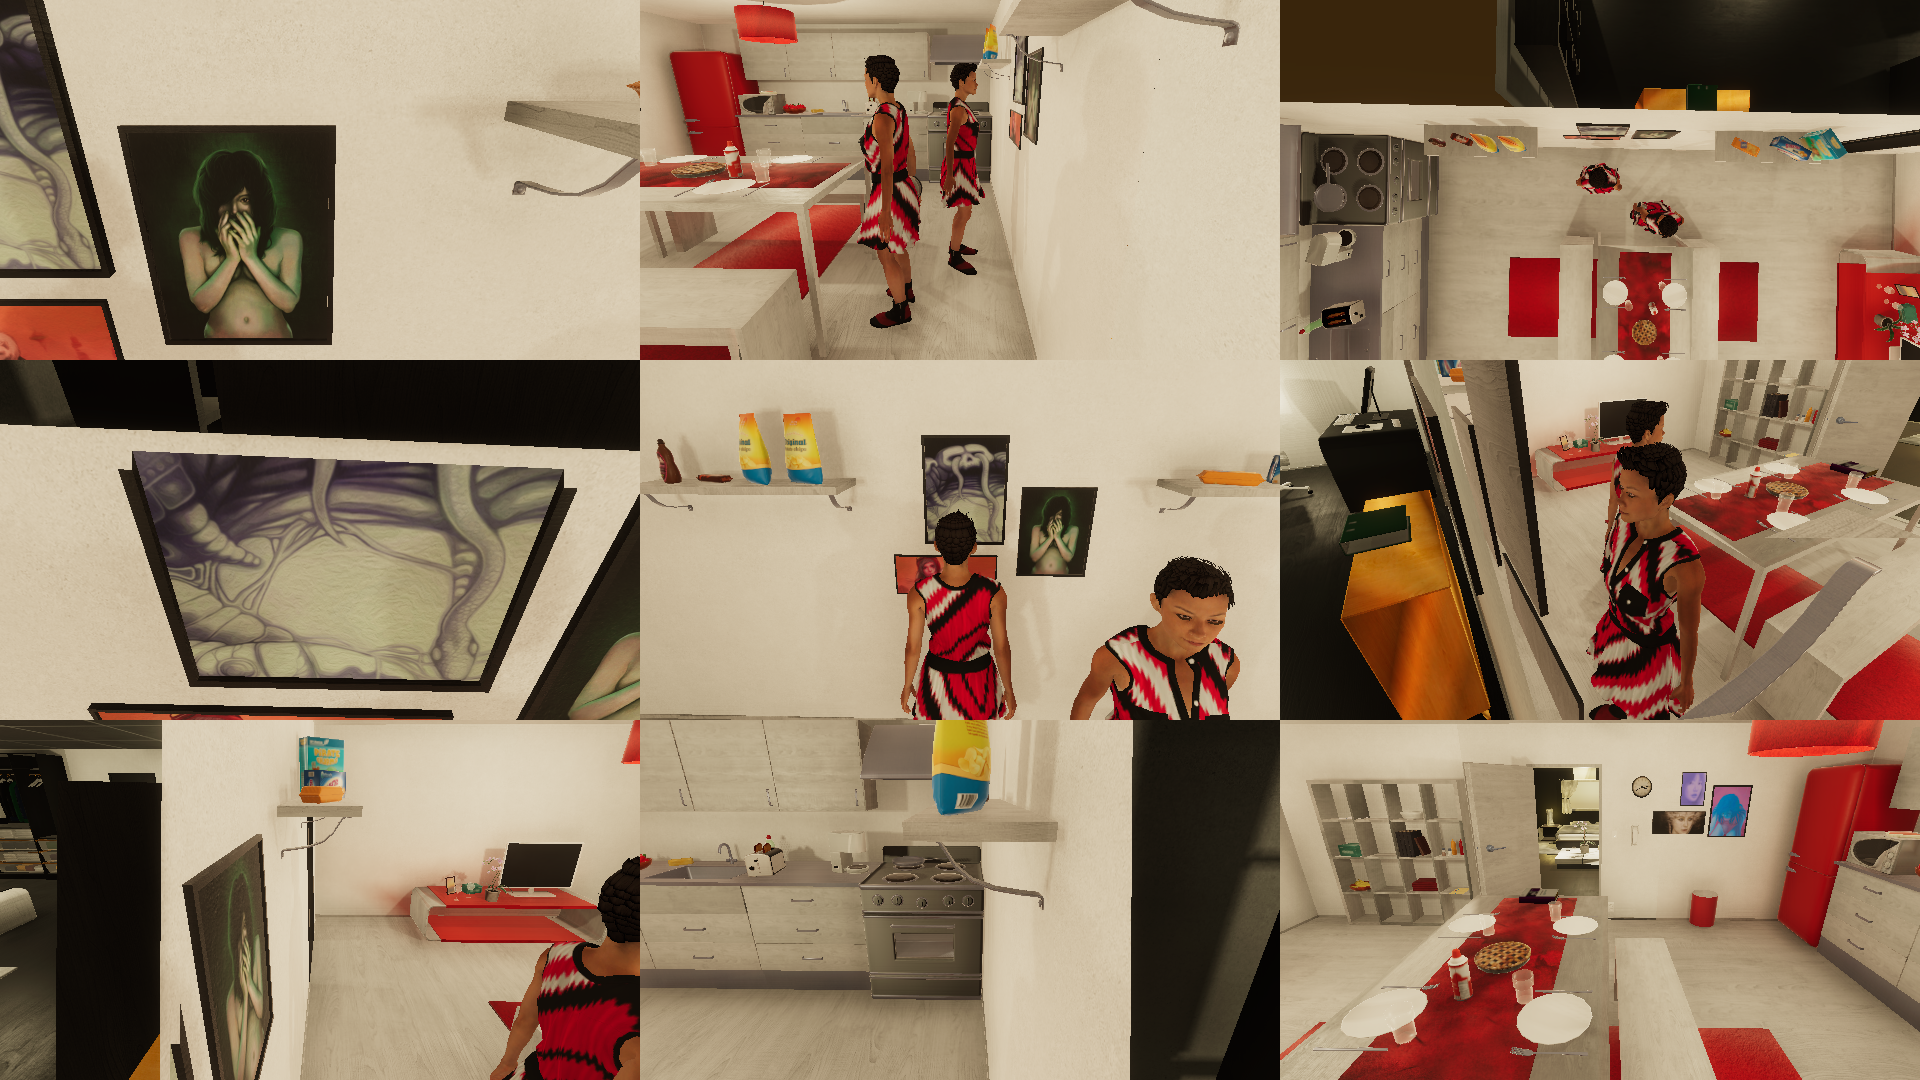

In [148]:
import json
import numpy as np

state_index = {'OPEN': 0, 'CLOSED': 1, 'ON': 2, 'OFF': 3, 'CLEAN':4}
room = {'bathroom', 'kitchen', 'livingroom', 'bedroom'}

properties = open('./resources/properties_data_all.json')
properties = json.load(properties)
properties['bathroom'] = []
properties['kitchen'] = []
properties['livingroom'] = []
properties['bedroom'] = []
properties['kitchencounterdrawer'] = properties.pop('kitchencounterdrawers')


_, graph = comm.environment_graph()
rooms_id = get_rooms_id(graph)
visible_objects_id = get_visible_objects_id(character_id, graph)
visible_objects_id = visible_objects_id.union(rooms_id)
partial_observation = get_observations(character_id, visible_objects_id, graph)
object_relationships = get_relationships(character_id, partial_observation, graph)

_, nc = comm.camera_count()
indices = range(nc - 9, nc)
imgs_prev = get_scene_cameras(comm, indices)
display_grid_img(imgs_prev, nrows=3)

## Extract data

In [ ]:
import torch
action_index = {'standup': 0, 'walk': 1, 'sit': 2, 'grab': 3, 'open': 4, 'close': 5, 'switchon': 6, 'switchoff': 7, 'put': 8, 'putin': 9}
object_index = {'kitchentable':0, 'coffeepot':1} # -1 means no object needed in action


def stack_np_array_on_base(arr, base):
    ex_arr = np.expand_dims(arr, 0)
    return np.vstack([ex_arr, base]) if base is not None else ex_arr

#hardcode sample data
goal = ['ON (coffeepot, kitchentable): 1']
history = []
coffeepot_id = partial_observation['ids'][np.where(partial_observation['names'] == 'coffeepot')][-1]
kitchentable_id = partial_observation['ids'][np.where(partial_observation['names'] == 'kitchentable')][-1]
script = ['<char0> [walk] <coffeepot> ({})'.format(coffeepot_id), '<char0> [grab] <coffeepot> ({})'.format(coffeepot_id), '<char0> [walk] <kitchentable> ({})'.format(kitchentable_id), '<char0> [put] <coffeepot> ({}) <kitchentable> ({})'.format(coffeepot_id, kitchentable_id)]

data = {'goal': [], 
        'history': [], 
        'obs_ids': None, 
        'obs_names': [],
        'obs_states': None,
        'obs_positions': None,
        'relationships': [], 
        'action_label': None, 
        'object_label': None}

for script_instruction in script:
    _, graph = comm.environment_graph()
    rooms_id = get_rooms_id(graph)
    visible_objects_id = get_visible_objects_id(character_id, graph)
    visible_objects_id = visible_objects_id.union(rooms_id)
    partial_observation = get_observations(character_id, visible_objects_id, graph)
    object_relationships = get_relationships(character_id, partial_observation, graph)

    word = script_instruction.split(' ')
    action = word[1][1: -1]
    action_label = np.array([action_index[action]])

    object_label = []
    if len(word) == 2:
        object_label += [-1, -1]
    elif len(word) == 4: # char0 put apple 40
        obj_id = int(word[3][1: -1])
        ind = np.where(partial_observation['ids']==obj_id)
        object_label += [object_index[partial_observation['names'][ind].item()], -1]
    elif len(word) == 6:
        obj_id1 = int(word[3][1: -1])
        obj_id2 = int(word[5][1: -1])
        ind_a = np.where(partial_observation['ids']==obj_id1)
        ind_b = np.where(partial_observation['ids']==obj_id2)
        object_label += [object_index[partial_observation['names'][ind_a].item()],
                         object_index[partial_observation['names'][ind_b].item()]]
    object_label = np.array(object_label)

    data['goal'] += [goal_translate(goal)]
    data['history'] += [history_translate(history)]
    for key in partial_observation:
        if key == 'names': continue
        data['obs_{}'.format(key)] = stack_np_array_on_base(partial_observation[key], data['obs_{}'.format(key)])
    data['obs_names'] += [" ".join(list(partial_observation['names']))]
    data['relationships'] += [object_relationships]
    data['action_label'] = stack_np_array_on_base(action_label, data['action_label'])
    data['object_label'] = stack_np_array_on_base(object_label, data['object_label'])

    history.append(script_instruction)
    comm.render_script([script_instruction], recording=False, skip_animation=True)

In [ ]:
data

In [145]:
for key in data:
    print(key)
    print("shape = ", end =' ')
    if type(data[key]) is list:
        print(len(data[key]))
    else:
        print(data[key].shape)

goal
shape =  4
history
shape =  4
obs_ids
shape =  (4, 256)
obs_names
shape =  4
obs_states
shape =  (4, 256, 6)
obs_positions
shape =  (4, 256, 6)
relationships
shape =  4
action_label
shape =  (4, 1)
object_label
shape =  (4, 2)


In [ ]:
#save sample data
!mkdir ./sample_data
for k in data:
    np.save('./sample_data/{}'.format(k), data[k])

In [ ]:
#export dataset
import shutil
shutil.make_archive('sample_data', 'zip', './sample_data')

'/content/virtualhome/sample_data.zip'

# Training

## Data loader and preprocess

In [ ]:
!pip install transformers

In [107]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2Model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [108]:
data_pth = "./sample_data"

In [158]:
class VHStructuredDataset(Dataset):
    def __init__(self, data_pth):
        self.data = {'goal': None, 
                    'history': None, 
                    'obs_ids': None, 
                    'obs_names': None,
                    'obs_states': None,
                    'obs_positions': None,
                    'relationships': None, 
                    'action_label': None, 
                    'object_label': None}
        for k in self.data:
            self.data[k] = np.load(os.path.join(data_pth,"{}.npy".format(k)), allow_pickle=True)

    def __getitem__(self, index):
        goal = self.data['goal'][index]
        history = self.data['history'][index]
        obs_ids = self.data['obs_ids'][index]
        obs_names = self.data['obs_names'][index] 
        obs_states = self.data['obs_states'][index]
        obs_positions = self.data['obs_positions'][index]
        #relationships = self.data['relationships'][index]
        relationships = []
        action_label = self.data['action_label'][index]
        object_label = self.data['object_label'][index]
        
        #return goal, history, obs_ids, obs_names, obs_states, obs_positions, action_label, object_label
        
        return {'goal': goal,
                'history': history,
                'obs_ids': obs_ids,
                'obs_names': obs_names,
                'obs_states': obs_states,
                'obs_positions': obs_positions,
                'relationships':relationships,
                'action_label':action_label,
                'object_label':object_label}
        
    def __len__(self):
        return len(self.data['goal'])

In [159]:
train_dataset = VHStructuredDataset(data_pth)
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    num_workers=2,
)

In [ ]:
for batch_ndx, sample in enumerate(train_loader):
    print(sample)

## Define preprocessing procedure

In [153]:
def get_tokenizer(lm):
    tokenizer = GPT2Tokenizer.from_pretrained(lm)
    return tokenizer

def get_word_embeddings(lm):
    model = GPT2Model.from_pretrained(lm)
    word_embeddings = model.wte.weight
    return word_embeddings

def embed(sentence, tokenizer, word_embeddings, max_len=128):
    #list sentence arg can be like ['I have a pen', 'I have an apple']
    tokenized = gpt2_tokenizer(sentence, max_length=max_len, pad_to_max_length=True, return_tensors="pt").input_ids.to(device)
    one_hot_tokenized = F.one_hot(tokenized, num_classes=50257).type(torch.float32)
    embeddings = one_hot_tokenized @ gpt2_word_embeddings
    return embeddings

def preprocess(data, tokenizer, embeddings):
    data['goal'] = embed(data['goal'], tokenizer, embeddings, max_len = 32)
    data['history'] = embed(data['history'], tokenizer, embeddings, max_len = 64)
    data['obs_names'] = embed(data['obs_names'], tokenizer, embeddings, max_len = 256)
    data['obs_states'] = data['obs_states'].type(torch.float32).to(device)
    data['obs_positions'] = data['obs_positions'].type(torch.float32).to(device)
    data['action_label'] = data['action_label'].to(device).squeeze()
    data['object_label'] = data['object_label'].to(device)
    return data

In [113]:
#define tokenizer and embedders
gpt2_tokenizer = get_tokenizer('gpt2')
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_word_embeddings = get_word_embeddings('gpt2').to(device)

## Define Model

In [150]:
class LMDecisionMaker(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layer in LM framework
        self.state_fc = nn.Linear(6, 768).to(device)
        self.position_fc1 = nn.Linear(6, 768).to(device)
        self.relu = nn.ReLU(inplace = True)
        self.position_fc2 = nn.Linear(768,  768).to(device)
        self.object_fc = nn.Linear(3 * 768, 768).to(device)
        self.action_fc = nn.Linear(768, 10).to(device)
        self.lm = GPT2Model.from_pretrained('gpt2').to(device)
    
    def lm_infer(self, input):
        with torch.no_grad:
            return self.lm(inputs_embeds=input).last_hidden_state

    def forward(self, goal, history, obs_ids, obs_names, obs_states, obs_positions, relationships, action_label, object_label, train_or_test='train'):
        
        goal_embeddings = goal
        
        history_embeddings = history
        
        name_embeddings = obs_names.unsqueeze(2)
        
        state_embeddings = self.state_fc(obs_states).unsqueeze(2)
        
        position_embeddings = self.position_fc2(self.relu(self.position_fc1(obs_positions))).unsqueeze(2)
        
        observation_embeddings = torch.cat((name_embeddings, state_embeddings, position_embeddings), 2)
        observation_embeddings = observation_embeddings.view(-1, 256, 3*768)
        observation_embeddings = self.object_fc(observation_embeddings)
        
        action_embeddings = torch.cat((goal_embeddings, history_embeddings, observation_embeddings),1)
        action_embeddings = self.lm_infer(action_embeddings)

        contextualized_feature = torch.mean(action_embeddings, 1)
        contextualized_feature_after_fc = self.action_fc(contextualized_feature)

        object_feature = self.lm_infer(observation_embeddings)

        action_prediction = torch.argsort(contextualized_feature_after_fc, descending=True)

        repeated_cf = contextualized_feature.unsqueeze(1).repeat(1,object_feature.shape[1], 1)
        inner_product = torch.sum(object_feature*repeated_cf, axis = -1)
        object_prediction = torch.argsort(inner_product, descending=True)

        loss = self.compute_loss(contextualized_feature_after_fc, inner_product, action_label, object_label)
        '''
        next_predicate, next_index = self.predictor(action_prediction, object_prediction, batch_observations, batch_relationships)
        if train_or_test == 'train':
            loss = self.compute_loss(contextualized_feature_after_fc, inner_product, action_label, object_label)
            accuracy = self.compute_accuracy(next_index, action_label, object_label)
            return loss, accuracy
        else:
            return next_predicate
        '''

        return loss

    def compute_loss(self, contextualized_feature_after_fc, inner_product, action_label, object_label):
        """
        Compute the cross entropy loss

        contextualized_feature_after_fc: a torch tensor with a size (10), showing the probability of 10 actions
        inner_product: a torch tensor with a size (len(observations)), showing the probability of all visible objects
        action label: a torch tensor of size (1), showing the true action label
        object label: a torch tensor of size (0) or (1) or (2), showing the true object labels

        return: the cross entropy loss of the action and objects
        """
        f.cross_entropy(inner_product.unsqueeze(0), object_label)
        return F.cross_entropy(contextualized_feature_after_fc, action_label) + 
        '''
        if object_label.shape[0] == 0:
            return f.cross_entropy(contextualized_feature_after_fc.unsqueeze(0), action_label)
        elif object_label.shape[0] == 1:
            return f.cross_entropy(contextualized_feature_after_fc.unsqueeze(0), action_label) + f.cross_entropy(inner_product.unsqueeze(0), object_label)
        elif object_label.shape[0] == 2:
            return f.cross_entropy(contextualized_feature_after_fc.unsqueeze(0), action_label) + f.cross_entropy(inner_product.unsqueeze(0), object_label[0].unsqueeze(0)) + f.cross_entropy(inner_product.unsqueeze(0), object_label[1].unsqueeze(0))
        '''


In [160]:
#define model
lm = LMDecisionMaker()

In [161]:
for batch_ndx, data in enumerate(train_loader):
    data = preprocess(data, gpt2_tokenizer, gpt2_word_embeddings )
    lm.forward(**data)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


torch.Size([4])
tensor(1.7108, device='cuda:0', grad_fn=<NllLossBackward0>)
done!


In [157]:
import gc 
with torch.no_grad():
    torch.cuda.empty_cache()
    gc.collect()

## Define Language Model

Define the function to add constraints on the action and object predictions

In [ ]:
action_space = {0: 'standup', 1: 'walk', 2:'sit', 3:'grab', 4:'open', 5:'close', 6:'switchon', 7:'switchoff', 8:'put', 9: 'putin'}

def judge_standup(sitting_edges):
    cond1 = len(sitting_edges) > 1
    return True if cond1 else False

def judge_walk(sitting_edges, inside_edges, hold_edges, obj, index):
    cond1 = len(sitting_edges) == 0
    cond2 = index not in inside_edges
    cond3 = obj in room
    cond4 = index not in hold_edges
    return True if cond1 and (cond2 or cond3) and cond4 else False

def judge_sit(sitting_edges, close_edges, obj, index):
    cond1 = len(sitting_edges) == 0
    cond2 = index in close_edges
    cond3 = 'SITTABLE' in properties[obj] if obj in properties else False
    return True if cond1 and cond2 and cond3 else False

def judge_grab(close_edges, inside_edges, hold_edges, obj, index):
    cond1 = 'GRABBABLE' in properties[obj] if obj in properties else False
    cond2 = obj != 'water'
    cond3 = index in close_edges
    cond4 = index not in inside_edges
    cond5 = index not in hold_edges
    cond6 = len(hold_edges) < 2
    return True if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 else False

def judge_open(observations, close_edges, inside_edges, hold_edges, obj, index):
    cond1 = 'CAN_OPEN' in properties[obj] if obj in properties else False
    cond2 = observations[index]['state'][1] = 1
    cond3 = index in close_edges
    cond4 = index not in inside_edges
    cond5 = index not in hold_edges
    cond6 = len(hold_edges) < 2
    return True if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 else False

def judge_close(observations, close_edges, inside_edges, hold_edges, obj, index):
    cond1 = 'CAN_OPEN' in properties[obj] if obj in properties else False
    cond2 = observations[index]['state'][0] = 1
    cond3 = index in close_edges
    cond4 = index not in inside_edges
    cond5 = index not in hold_edges
    cond6 = len(hold_edges) < 2
    return True if cond1 and cond2 and cond3 and cond4 and cond5 and cond6 else False

def judge_switchon(observations, close_edges, obj, index):
    cond1 = 'HAS_SWITCH' in properties[obj] if obj in properties else False
    cond2 = observations[index]['state'][3] == 1
    cond3 = index in close_edges
    return True if cond1 and cond2 and cond3 else False

def judge_switchoff(observations, close_edges, obj, index):
    cond1 = 'HAS_SWITCH' in properties[obj] if obj in properties else False
    cond2 = observations[index]['state'][2] == 1
    cond3 = index in close_edges
    return True if cond1 and cond2 and cond3 else False

def judge_put(hold_edges, close_edges, index1, index2):
    cond1 = index1 in hold_edges
    cond2 = index2 in close_edges
    return True if cond1 and cond2 else False

def judge_putin(observations, hold_edges, close_edges, index1, index2):
    cond1 = index1 in hold_edges
    cond2 = index2 in close_edges
    cond3 = observations[index2]['state'][1] != 1
    return True if cond1 and cond2 and cond3 else False

def judge_0(relationships):
    sitting_edges = relationships['sitting']
    return judge_standup(sitting_edges)

def judge_1(action, obj, index, relationships, observations):
    sitting_edges = relationships['sitting']
    close_edges = relationships['close']
    inside_edges = relationships['inside']
    hold_edges = relationships['hold']
    if action == 'walk':
        return judge_walk(sitting_edges, inside_edges, hold_edges, obj, index)
    elif action == 'sit':
        return judge_sit(sitting_edges, close_edges, obj, index)
    elif action == 'grab':
        return judge_grab(close_edges, inside_edges, hold_edges, obj, index)
    elif action == 'open':
        return judge_open(observations, close_edges, inside_edges, hold_edges, obj, index)
    elif action == 'close':
        judge_close(observations, close_edges, inside_edges, hold_edges, obj, index)
    elif action == 'switchon':
        return judge_switchon(observations, close_edges, obj, index)
    elif action == 'switchoff':
        return judge_switchoff(observations, close_edges, obj, index)

def judge_2(action, index1, index2, relationships, observations):
    close_edges = relationships['close']
    hold_edges = relationships['hold']
    if action == 'put':
        return judge_put(hold_edges, close_edges, index1, index2)
    elif action == 'putin':
        judge_putin(observations, hold_edges, close_edges, index1, index2)

Training and evaluating algorithm

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as f

def array_to_2d_tensor(array):
    if len(array.shape) > 1:
        return torch.tensor(array).to(device)
    return torch.tensor(array).unsqueeze(0).to(device)

def gpt2_model(embeddings):
    model = GPT2Model.from_pretrained('gpt2').to(device)
    return model(inputs_embeds=embeddings).last_hidden_state # N*768 N-> length of the info max 1024 => 1023*768

class LM(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layer in LM framework
        self.state_fc = nn.Linear(6, 3 * 768)

        self.position_fc1 = nn.Linear(6, 3 * 768)
        self.relu = nn.ReLU(inplace=True)
        self.position_fc2 = nn.Linear(3 * 768, 3 * 768)

        self.object_fc = nn.Linear(7 * 768, 768) #->obj label?

        self.action_fc = nn.Linear(768, 10)

    def forward(self, batch_goal, batch_history, batch_observations, batch_relationships, batch_action_label, batch_object_label, train_or_test='train'):
        """
        Forward pass of the neural network

        return: a tuple (loss, accuracy) of two torch Float scalars representing the cross entropy loss and mean accuracy of the batch
        """
        start = time.time()
        templated_goals = [goal_translate(goal) for goal in batch_goal]
        templated_histories = [history_translate(history) for history in batch_history]
        end = time.time()
        print("Template Translation : {}".format(end-start))

        # embed goal
        start = time.time()
        goal_embeddings = batch_embed(templated_goals, gpt2_tokenizer, gpt2_word_embeddings)
        end = time.time()
        print("Goal Embedding: {}".format(end-start))
        print("Shape:{}".format(goal_embeddings.shape))
        
        # embed history
        start = time.time()
        history_embeddings = batch_embed(templated_histories, gpt2_tokenizer, gpt2_word_embeddings)
        end = time.time()
        print("History Embedding: {}".format(end-start))
        print("Shape:{}".format(history_embeddings.shape)) # N*12*768
        
        # embed partial observation
        start = time.time()
        observation_embeddings = []
        for visible_object in batch_observations.values():
            # embed name
            name_embeddings = batch_embed(visible_object['name'], gpt2_tokenizer, gpt2_word_embeddings)
            name_embeddings = torch.mean(name_embeddings, -1)

            # embed state
            state = torch.tensor(visible_object['state'], dtype=torch.float).to(device)
            state_embeddings = self.state_fc(state).unsqueeze(0)

            # embed position
            position = torch.tensor(visible_object['position'], dtype=torch.float).to(device)
            position_embeddings = self.position_fc1(position)
            position_embeddings = self.relu(position_embeddings)
            position_embeddings = self.position_fc2(position_embeddings).unsqueeze(0)

            # concatenate object embeddings and pass through fc layer
            object_embeddings = torch.cat((name_embeddings, state_embeddings, position_embeddings), 1)
            object_embeddings = self.object_fc(object_embeddings).view(-1, 768)
            observation_embeddings.append(object_embeddings)

        # concatenate all object embeddings
        observation_embeddings = torch.cat(observation_embeddings)
        end = time.time()
        print("Obs Embedding: {}".format(end-start))
        print("Shape:{}".format(observation_embeddings.shape))

        # concatenate goal, history and observations and pass them through LM
        start = time.time()
        action_embeddings = torch.cat((goal_embeddings, history_embeddings, observation_embeddings))
        action_embeddings = gpt2_model(action_embeddings[:1023])
        end = time.time()
        print("action embedding: {}".format(end-start))

        # pass LM output to the average pooling to get contextualized feature and predict the next action
        contextualized_feature = torch.mean(action_embeddings, 0)
        contextualized_feature_after_fc = self.action_fc(contextualized_feature)
        action_prediction = torch.argsort(contextualized_feature_after_fc, descending=True)

        # pass the observation embeddings through LM and compute the inner product of each object feature with contextualized feature, then make the object prediction
        start = time.time()
        object_feature = gpt2_model(observation_embeddings[:1023])
        end = time.time()
        print("obj feature: {}".format(end-start))
        inner_product = object_feature.unsqueeze(1).bmm(contextualized_feature.repeat(object_feature.shape[0]).view(object_feature.shape[0], -1, 1)).squeeze()
        object_prediction = torch.argsort(inner_product, descending=True)

        next_predicate, next_index = self.predictor(action_prediction, object_prediction, batch_observations, batch_relationships)
        if train_or_test == 'train':
            loss = self.compute_loss(contextualized_feature_after_fc, inner_product, action_label, object_label)
            accuracy = self.compute_accuracy(next_index, action_label, object_label)
            return loss, accuracy
        else:
            return next_predicate
  
    def predictor(self, action_prediction, object_prediction, observations, relationships):
        """
        Compute the loss and accuracy

        action_prediction: a torch tensor with a size (10), showing the probability of 10 actions
        object_prediction: a torch tensor with a size (len(observations)), showing the probability of all visible objects
        observations: a dictionary mapping the visible object (including all rooms) id to name, state vector and position vector
        relationships: a dictionary containing 4 relationship dictionary: sitting, close, inside, hold

        return: a predicate string in the form of VirtualHome format without character, e.g. '[walk] <chair> (1)'
        """
        for action_id in action_prediction:
            if int(action_id.cpu().numpy()) == 0 and judge_0(relationships):
                return '[{}]'.format(action_space[int(action_id.cpu().numpy())]), (action_id, torch.tensor([-1]).to(device), torch.tensor([-1]).to(device))

            elif 1 <= int(action_id.cpu().numpy()) <= 7:
                action = action_space[int(action_id.cpu().numpy())]
                for object_id in object_prediction:
                    obj = observations[list(observations.keys())[int(object_id.cpu().numpy())]]['name']
                    index = list(observations.keys())[int(object_id.cpu().numpy())]
                    if judge_1(action, obj, index, relationships, observations):
                        return '[{}] <{}> ({})'.format(action, obj, index), (action_id, object_id, torch.tensor([-1]).to(device))

            elif int(action_id.cpu().numpy()) >= 8:
                action = action_space[int(action_id.cpu().numpy())]
                for i in range(len(object_prediction)):
                    obj1 = observations[list(observations.keys())[int(object_prediction[i].cpu().numpy())]]['name']
                    index1 = list(observations.keys())[int(object_prediction[i].cpu().numpy())]
                    for j in range(i + 1, len(object_prediction)):
                        obj2 = observations[list(observations.keys())[int(object_prediction[j].cpu().numpy())]]['name']
                        index2 = list(observations.keys())[int(object_prediction[j].cpu().numpy())]
                        if judge_2(action, index1, index2, relationships, observations):
                            return '[{}] <{}> ({}) <{}> ({})'.format(action, obj1, index1, obj2, index2), (action_id, object_prediction[i], object_prediction[j])
            
    def compute_loss(self, contextualized_feature_after_fc, inner_product, action_label, object_label):
        """
        Compute the cross entropy loss

        contextualized_feature_after_fc: a torch tensor with a size (10), showing the probability of 10 actions
        inner_product: a torch tensor with a size (len(observations)), showing the probability of all visible objects
        action label: a torch tensor of size (1), showing the true action label
        object label: a torch tensor of size (0) or (1) or (2), showing the true object labels

        return: the cross entropy loss of the action and objects
        """
        if object_label.shape[0] == 0:
            return f.cross_entropy(contextualized_feature_after_fc.unsqueeze(0), action_label)
        elif object_label.shape[0] == 1:
            return f.cross_entropy(contextualized_feature_after_fc.unsqueeze(0), action_label) + f.cross_entropy(inner_product.unsqueeze(0), object_label)
        elif object_label.shape[0] == 2:
            return f.cross_entropy(contextualized_feature_after_fc.unsqueeze(0), action_label) + f.cross_entropy(inner_product.unsqueeze(0), object_label[0].unsqueeze(0)) + f.cross_entropy(inner_product.unsqueeze(0), object_label[1].unsqueeze(0))

    def compute_accuracy(self, next_index, action_label, object_label):
        """
        Compute the accuracy

        next_index: a tuple with three torch tensors with size (1), each indicates the index of the action and objects
        action label: a torch tensor of size (1), showing the true action label
        object label: a torch tensor of size (0) or (1) or (2), showing the true object labels

        return: the cross entropy loss of the action and objects
        """
        if object_label.shape[0] == 0:
            action_accuracy = 1 if int(next_index[0].cpu().numpy()) == int(action_label[0].cpu().numpy()) else 0
            return action_accuracy
        elif object_label.shape[0] == 1:
            action_accuracy = 0.5 if int(next_index[0].cpu().numpy()) == int(action_label[0].cpu().numpy()) else 0
            object_accuracy = 0.5 if int(next_index[1].cpu().numpy()) == int(object_label[0].cpu().numpy()) else 0
            return action_accuracy + object_accuracy
        elif object_label.shape[0] == 2:
            action_accuracy = 1/3 if int(next_index[0].cpu().numpy()) == int(action_label[0].cpu().numpy()) else 0
            object_accuracy1 = 1/3 if int(next_index[1].cpu().numpy()) == int(object_label[0].cpu().numpy()) else 0
            object_accuracy2 = 1/3 if int(next_index[2].cpu().numpy()) == int(object_label[1].cpu().numpy()) else 0
            return action_accuracy + object_accuracy1 + object_accuracy2

def train(net, num_steps):
    """
    Train the input neural network for num_steps

    net: LM framework
    num_steps: number of batches to train for

    return: the trained net, the training accuracies per step, and the validation accuracies per steps
    """
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)
    train_accuracies = []
    val_accuracies = []
    for step, batch in zip(range(num_steps), train_dataset):
        train_loss = torch.tensor([0], dtype=torch.float).to(device)
        train_accuracy = 0
        batch_size = batch.shape[0]
        for data in batch:
            goal, history, observations, relationships, action_label, object_label = data['goal'], data['history'], data['observations'], data['relationships'], data['action_label'], data['object_label']
            loss, accuracy = net(goal, history, observations, relationships, action_label, object_label, 'train')

            train_loss += loss / batch_size
            train_accuracy += accuracy / batch_size

        opt.zero_grad()
        train_loss.backward()
        opt.step()

        train_accuracies.append(train_accuracy)
        if (step + 1) % 1 == 0:
            val_loss, val_accuracy = validate(net, val_dataset)
            val_accuracies.append(val_accuracy)
            print('step=%s   train(loss=%.5g, accuracy=%.5g)  val(loss=%.5g, accuracy=%.5g)' % (step + 1, train_loss, train_accuracy, val_loss, val_accuracy))
    return net, train_accuracies, val_accuracies

def validate(net, val_dataset):
    """
    Evalate the trained net on val_dataset

    net: LM framework
    val_dataset: validation dataset

    return: a tuple (val_loss, val_accuracy)
    """
    with torch.no_grad():
        batch = next(iter(val_dataset))
        batch_size = batch.shape[0]
        loss_sum = torch.tensor([0], dtype=torch.float).to(device)
        accuracy_sum = 0
        for data in batch:
            goal, history, observations, relationships, action_label, object_label = data['goal'], data['history'], data['observations'], data['relationships'], data['action_label'], data['object_label']
            loss, accuracy = net(goal, history, observations, relationships, action_label, object_label, 'train')

            loss_sum += loss / batch_size
            accuracy_sum += accuracy / batch_size

        val_loss, val_accuracy = loss_sum, accuracy_sum
    return val_loss, val_accuracy

In [ ]:
print("Launching training on {}".format(device))

Launching training on cuda


In [ ]:
nets = {}
train_steps = 10 # change as needed
plt.figure(figsize=(20, 10))

Net = LM
nets[Net], train_accs, val_accs = train(Net(), train_steps)

plt.plot((1 + np.arange(len(val_accs))), val_accs, label=Net.__name__)
plt.xlabel('training step')
plt.ylabel('validation accuracy')
plt.legend()
plt.show()

# Test the model

In [ ]:
test_goal = ['ON (coffeepot, kitchentable): 1']
test_hostory = []
success_predicate = ['[put] <coffeepot> <kitchentable>']
comm.reset(6)

character_id = create_character('chars/Female2', 'livingroom')
rooms_id = get_rooms_id()

num = 0
while num < 5:
    visible_objects_id = get_visible_objects_id(character_id)
    visible_objects_id = visible_objects_id.union(rooms_id)
    partial_observation = get_observations(character_id, visible_objects_id)
    object_relationships = get_relationships(character_id, partial_observation)

    next_predicate = nets[Net](test_goal, test_hostory, partial_observation, object_relationships, None, None, 'test')
    print(next_predicate)
    if next_predicate in success_predicate:
        break

    comm.render_script(['<char0> ' + next_predicate], recording=False, skip_animation=True)

    test_hostory.append(next_predicate)
    num += 1
print(test_hostory)